In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, f1_score, balanced_accuracy_score

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

In [10]:
# Function to extract the performance metrics
def performance_metrics(y_test,y_pred):
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    roc_auc = round(roc_auc_score(y_test, y_pred),4)

    #calculate optimal roc auc threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresh[optimal_idx]
    y_optimal = y_pred>optimal_threshold

    #compute f1 score, precision recall AUC, balanced accuracy
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    f1 = f1_score(y_test, y_optimal)
    balanced_accuracy =balanced_accuracy_score(y_test, y_optimal)
    return f1, pr_auc, balanced_accuracy, roc_auc

In [2]:
# Import the data
df_train = pd.read_csv('ptbdb_train.csv', header=None)
df_test = pd.read_csv('ptbdb_test.csv', header=None)

# Separate last column as target for train data
data_matrix_train = df_train.values
y_train = data_matrix_train[:,-1]
X_train = data_matrix_train[:,0:-1]

# Separate last column as target for test data
data_matrix_test = df_test.values
y_test = data_matrix_test[:,-1]
X_test = data_matrix_test[:,0:-1]

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)

Train data shape: (11641, 187)
Test data shape: (2911, 187)


In [4]:
# Seed for reproducibility
random_seed = 13
np.random.seed(random_seed)

In [5]:
# Task (1)

# Train random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
rf.fit(X_train, y_train)

# Train MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,100), random_state=random_seed)
mlp.fit(X_train, y_train)

# Train kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Train naive bayes classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict probabilities for each classifier
y_pred_rf = rf.predict_proba(X_test)[:,1]
y_pred_mlp = mlp.predict_proba(X_test)[:,1]
y_pred_knn = knn.predict_proba(X_test)[:,1]
y_pred_nb = nb.predict_proba(X_test)[:,1]

In [15]:
models = [rf, mlp, knn, nb]
y_preds = [y_pred_rf, y_pred_mlp, y_pred_knn, y_pred_nb]

for model, y_pred in zip(models, y_preds):
    f1, pr_auc, balanced_accuracy, roc_auc = performance_metrics(y_test, y_pred)
    
    print(f'Model: {model.__class__.__name__}')
    print(f'F1 score: {f1:.4f}')
    print(f'PR AUC: {pr_auc:.4f}')
    print(f'Balanced accuracy: {balanced_accuracy:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print('------------------------')

Model: RandomForestClassifier
F1 score: 0.9772
PR AUC: 0.9973
Balanced accuracy: 0.9660
ROC AUC: 0.9937
------------------------
Model: MLPClassifier
F1 score: 0.9768
PR AUC: 0.9939
Balanced accuracy: 0.9621
ROC AUC: 0.9871
------------------------
Model: KNeighborsClassifier
F1 score: 0.8903
PR AUC: 0.9911
Balanced accuracy: 0.8978
ROC AUC: 0.9764
------------------------
Model: GaussianNB
F1 score: 0.7926
PR AUC: 0.8904
Balanced accuracy: 0.7049
ROC AUC: 0.7585
------------------------


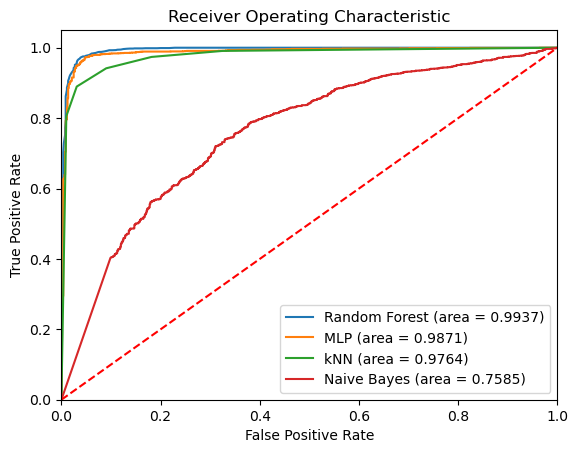

In [17]:
# Calculate ROC-AUC for each classifier
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
roc_auc_mlp = roc_auc_score(y_test, y_pred_mlp)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)
roc_auc_nb = roc_auc_score(y_test, y_pred_nb)

#Calculate ROC curves for each classifier
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_mlp)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)

#plot ROC curves
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.4f)' % roc_auc_rf)
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = %0.4f)' % roc_auc_mlp)
plt.plot(fpr_knn, tpr_knn, label='kNN (area = %0.4f)' % roc_auc_knn)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (area = %0.4f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
#Task (2): Add features to time-series

# Create a time-series dataframe with train dataset
df_train = pd.read_csv('ptbdb_train.csv', header=None)
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
melted_df = X_train.melt(var_name='time', value_name='values')
melted_df['id'] = melted_df.groupby('time').cumcount()
timeseries = melted_df[['id', 'time', 'values']]

y = pd.DataFrame({'id': range(len(y_train)), 'lbl': y_train})
y_series = y['lbl']


In [21]:
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")
print('Extracted_features shape:', extracted_features.shape)

Feature Extraction: 100%|██████████| 40/40 [15:06<00:00, 22.67s/it]  


Extracted_features shape: (11641, 783)


In [23]:
# Filter features by importance
impute(extracted_features)
features_filtered = select_features(extracted_features, y_series)

c:\Users\lucia\anaconda3\envs\mlhc\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['values__fft_coefficient__attr_"real"__coeff_94'
 'values__fft_coefficient__attr_"real"__coeff_95'
 'values__fft_coefficient__attr_"real"__coeff_96'
 'values__fft_coefficient__attr_"real"__coeff_97'
 'values__fft_coefficient__attr_"real"__coeff_98'
 'values__fft_coefficient__attr_"real"__coeff_99'
 'values__fft_coefficient__attr_"imag"__coeff_94'
 'values__fft_coefficient__attr_"imag"__coeff_95'
 'values__fft_coefficient__attr_"imag"__coeff_96'
 'values__fft_coefficient__attr_"imag"__coeff_97'
 'values__fft_coefficient__attr_"imag"__coeff_98'
 'values__fft_coefficient__attr_"imag"__coeff_99'
 'values__fft_coefficient__attr_"abs"__coeff_94'
 'values__fft_coefficient__attr_"abs"__coeff_95'
 'values__fft_coefficient__attr_"abs"__coeff_96'
 'values__fft_coefficient__attr_"abs"__coeff_97'
 'values__fft_coefficient__attr_"abs"__coeff_98'
 'values__fft_coefficient__a

In [24]:
# X_train_features is features_filtered concatenated to X_train
X_train_features = pd.concat([X_train, features_filtered], axis=1)
X_train_features.columns = range(X_train_features.shape[1])
y_train_features = y_train

print(X_train_features.shape, y_train_features.shape)

(11641, 782) (11641,)


In [25]:
#train random forest classifier
rf2 = RandomForestClassifier(n_estimators=100, random_state=random_seed)
rf2.fit(X_train_features, y_train_features)

#train MLP classifier
mlp2 = MLPClassifier(hidden_layer_sizes=(100,100), random_state=random_seed)
mlp2.fit(X_train_features, y_train_features)

#train kNN classifier
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(X_train_features, y_train_features)

#train naive bayes classifier
nb2 = GaussianNB()
nb2.fit(X_train_features, y_train_features)

GaussianNB()

In [26]:
# Create a time-series dataframe with test dataset

df_test = pd.read_csv('ptbdb_test.csv', header=None)
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]
melted_df = X_test.melt(var_name='time', value_name='values')
melted_df['id'] = melted_df.groupby('time').cumcount()
test_timeseries = melted_df[['id', 'time', 'values']]

In [27]:
extracted_features_test = extract_features(test_timeseries, column_id="id", column_sort="time")
test_features_filtered = extracted_features_test.filter(items=features_filtered.columns)
impute(test_features_filtered) # Impute nan values
print('Test features shape:', test_features_filtered.shape)

X_test_features = pd.concat([X_test, test_features_filtered], axis=1)
X_test_features.columns = range(X_test_features.shape[1])

Feature Extraction: 100%|██████████| 40/40 [04:02<00:00,  6.07s/it]


Test features shape: (2911, 595)


In [28]:
# Predict probabilities for each classifier
y_pred_rf = rf2.predict_proba(X_test_features.values)[:,1]
y_pred_mlp = mlp2.predict_proba(X_test_features.values)[:,1]
y_pred_knn = knn2.predict_proba(X_test_features.values)[:,1]
y_pred_nb = nb2.predict_proba(X_test_features.values)[:,1]

models = [rf2, mlp2, knn2, nb2]
y_preds = [y_pred_rf, y_pred_mlp, y_pred_knn, y_pred_nb]

for model, y_pred in zip(models, y_preds):
    f1, pr_auc, balanced_accuracy, roc_auc = performance_metrics(y_test, y_pred)
    
    print(f'Model: {model.__class__.__name__}')
    print(f'F1 score: {f1:.4f}')
    print(f'PR AUC: {pr_auc:.4f}')
    print(f'Balanced accuracy: {balanced_accuracy:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print('------------------------')

Model: RandomForestClassifier
F1 score: 0.9861
PR AUC: 0.9980
Balanced accuracy: 0.9809
ROC AUC: 0.9962
------------------------
Model: MLPClassifier
F1 score: 0.9432
PR AUC: 0.9889
Balanced accuracy: 0.9268
ROC AUC: 0.9749
------------------------
Model: KNeighborsClassifier
F1 score: 0.7136
PR AUC: 0.9629
Balanced accuracy: 0.7686
ROC AUC: 0.9073
------------------------
Model: GaussianNB
F1 score: 0.8587
PR AUC: 0.9152
Balanced accuracy: 0.7493
ROC AUC: 0.8170
------------------------


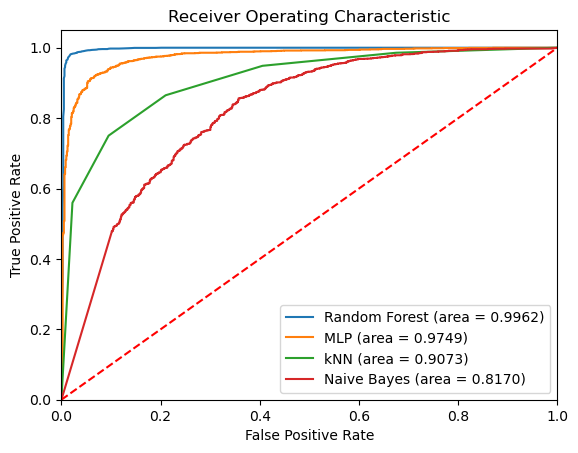

In [29]:
# Calculate ROC-AUC for each classifier
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
roc_auc_mlp = roc_auc_score(y_test, y_pred_mlp)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)
roc_auc_nb = roc_auc_score(y_test, y_pred_nb)

#Calculate ROC curves for each classifier
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_mlp)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)

#plot ROC curves
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.4f)' % roc_auc_rf)
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = %0.4f)' % roc_auc_mlp)
plt.plot(fpr_knn, tpr_knn, label='kNN (area = %0.4f)' % roc_auc_knn)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (area = %0.4f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()